In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.spatial.distance import pdist, squareform

from umap import UMAP

%matplotlib inline

In [4]:
df = pd.read_csv("../datas/prepared/final_dataset_with_omdb.csv", index_col=0, encoding="ISO-8859-1")

In [5]:
df[df.columns[:-50]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 27406 entries, tt0003037 to tt7889682
Data columns (total 67 columns):
primaryTitle      27406 non-null object
originalTitle     27406 non-null object
startYear         27406 non-null float64
runtimeMinutes    27406 non-null int64
averageRating     27406 non-null float64
numVotes          27406 non-null int64
Action            27406 non-null int64
Adventure         27406 non-null int64
Animation         27406 non-null int64
Biography         27406 non-null int64
Comedy            27406 non-null int64
Crime             27406 non-null int64
Drama             27406 non-null int64
Family            27406 non-null int64
Fantasy           27406 non-null int64
Film-Noir         27406 non-null int64
History           27406 non-null int64
Horror            27406 non-null int64
Musical           27406 non-null int64
Mystery           27406 non-null int64
Romance           27406 non-null int64
Sci-Fi            27406 non-null int64
Sport             27

In [6]:
df[df.columns[-50:]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 27406 entries, tt0003037 to tt7889682
Data columns (total 50 columns):
France            27406 non-null int64
Germany           27406 non-null int64
Hong Kong         27406 non-null int64
India             27406 non-null int64
Italy             27406 non-null int64
Japan             27406 non-null int64
Mexico            27406 non-null int64
Spain             27406 non-null int64
Sweden            27406 non-null int64
Turkey            27406 non-null int64
UK                27406 non-null int64
USA               27406 non-null int64
Lang_En           27406 non-null int64
Lang_Fr           27406 non-null int64
Topic_0           27406 non-null float64
Topic_1           27406 non-null float64
Topic_2           27406 non-null float64
Topic_3           27406 non-null float64
Topic_4           27406 non-null float64
Topic_5           27406 non-null float64
Topic_6           27406 non-null float64
Topic_7           27406 non-null float64
Topic_8   

In [7]:
df = df[df.startYear > 1995]
df.head()

,primaryTitle,originalTitle,startYear,runtimeMinutes,averageRating,numVotes,Action,Adventure,Animation,Biography,...,prod_WB,prod_Sony,prod_VCI,prod_Disney,prod_Indep,prod_MGM,prod_Fox,prod_Universal,prod_Lion,prod_Paramount
tconst,,,,,,,,,,,,,,,,,,,,,
tt0035423,Kate & Leopold,Kate & Leopold,2001.0,118,6.4,70611,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0096056,Crime and Punishment,Crime and Punishment,2002.0,126,6.3,567,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0110125,The Cold Light of Day,The Cold Light of Day,1996.0,96,6.4,620,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0112433,Baby Face Nelson,Baby Face Nelson,1996.0,93,5.6,172,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0112444,My Teacher's Wife,My Teacher's Wife,1999.0,89,5.6,1417,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Required Scaling

Move to log for too big scale

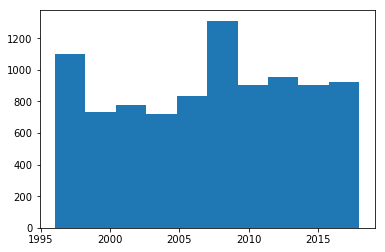

In [8]:
plt.hist(df.startYear)
plt.show()

In [9]:
avg_duration = df[df.runtimeMinutes < 1000].runtimeMinutes.mean()
df.loc[df.runtimeMinutes > 1000, "runtimeMinutes"] = avg_duration

# Encoded version

In [10]:
X = df.drop(["primaryTitle", "originalTitle"], axis=1)

In [11]:
X.numVotes = np.log(X.numVotes)

In [12]:
X.BoxOffice = X.BoxOffice.fillna(1)
X.BoxOffice = np.log(X.BoxOffice)

In [13]:
# a movie with 10 oscar is not 10 times better than a movie with 1 oscar, so a log is also a good but log(n+1) as lot of movies have 0 rewards

X.oscar_won = np.log(X.oscar_won + 1)
X.oscar_nom = np.log(X.oscar_nom + 1)
X.gg_won = np.log(X.gg_won + 1)
X.gg_nom = np.log(X.gg_nom + 1)
X.bafta_won = np.log(X.bafta_won + 1)
X.bafta_nom = np.log(X.bafta_nom + 1)
X.other_win = np.log(X.other_win + 1)
X.other_nom = np.log(X.other_nom + 1)

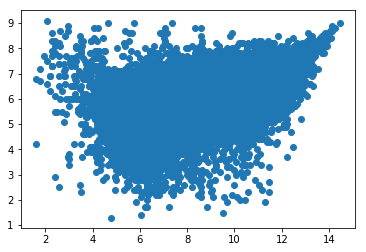

In [14]:
plt.scatter(X.numVotes, X.averageRating)
plt.show()

In [15]:
X["startYear"] = MinMaxScaler().fit_transform(X[["startYear"]])
X["averageRating"] = MinMaxScaler().fit_transform(X[["averageRating"]])
X["Metascore"] = MinMaxScaler().fit_transform(X[["Metascore"]])
X["Score_RT"] = MinMaxScaler().fit_transform(X[["Score_RT"]])

X["runtimeMinutes"] = StandardScaler().fit_transform(X[["runtimeMinutes"]])
X["numVotes"] = StandardScaler().fit_transform(X[["numVotes"]])
X["BoxOffice"] = StandardScaler().fit_transform(X[["BoxOffice"]])

X["oscar_won"] = MinMaxScaler().fit_transform(X[["oscar_won"]])
X["oscar_nom"] = MinMaxScaler().fit_transform(X[["oscar_nom"]])
X["gg_won"] = MinMaxScaler().fit_transform(X[["gg_won"]])
X["gg_nom"] = MinMaxScaler().fit_transform(X[["gg_nom"]])
X["bafta_won"] = MinMaxScaler().fit_transform(X[["bafta_won"]])
X["bafta_nom"] = MinMaxScaler().fit_transform(X[["bafta_nom"]])
X["other_win"] = MinMaxScaler().fit_transform(X[["other_win"]])
X["other_nom"] = MinMaxScaler().fit_transform(X[["other_nom"]])

# for col in df:
#     if col.startswith("Topic_"):
#         X[col] = MinMaxScaler().fit_transform(X[[col]])

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9150 entries, tt0035423 to tt7889682
Columns: 115 entries, startYear to prod_Paramount
dtypes: float64(35), int64(80)
memory usage: 8.4+ MB


# Conversion du Distance Matrices

In [17]:
X['mean'] = X[["averageRating", "Metascore", "Score_RT"]].mean(axis=1)

In [18]:
group0 = ["mean", "numVotes"] # ["averageRating", "numVotes", "Metascore", "Score_RT"]   # 4
group1 = ["startYear", "runtimeMinutes", "BoxOffice"]             # 7
group2 = X.columns[4:24]                                          # 27
group3 = X.columns[X.columns.str.startswith("Cluster_")]          # 37
group4 = X.columns[X.columns.str.startswith("Director_")]         # 45
group5 = X.columns[X.columns.str.startswith("Writer_")]           # 53
group6 = X.columns[X.columns.str.startswith("Topic_")]            # 73
group7 = X.columns[60:79]                                         # 92
group8 = X.columns[X.columns.str.startswith("prod_")]             # 102
group9 = X.columns[52:60]                                         # 110
group10 = X.columns[99:104]                                       # 115

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9150 entries, tt0035423 to tt7889682
Columns: 116 entries, startYear to mean
dtypes: float64(36), int64(80)
memory usage: 8.5+ MB


In [19]:
df[group6] = df[group6].div(df[group6].sum(axis=1), axis=0).fillna(0)

In [20]:
df[group10].head()

,All_age,Min_13,All_PG,Min_16,Min_17
tconst,,,,,
tt0035423,0,1,1,1,1
tt0096056,0,0,0,0,0
tt0110125,0,0,0,0,0
tt0112433,0,0,0,1,1
tt0112444,0,0,0,1,1


In [37]:
d0 = pdist(X[group0], metric='euclidean')  # ranking
d1 = pdist(X[group1], metric='euclidean')  # year, time, BO
d2 = pdist(X[group2], metric='hamming')    # movie style
d3 = pdist(X[group3], metric='hamming')    # cluster actors
d4 = pdist(X[group4], metric='hamming')    # director
d5 = pdist(X[group5], metric='hamming')    # writer
d6 = pdist(X[group6], metric="braycurtis") # Topic
d7 = pdist(X[group7], metric='hamming')    # country
d8 = pdist(X[group8], metric='hamming')    # distrib
d9 = pdist(X[group9], metric='Minkowski', p=2**0.5)  # win
d10= pdist(X[group10], metric='hamming')   # rated

In [52]:
d6 = np.nan_to_num(d6)

In [55]:
d0 = (d0-d0.min())/d0.max()
d1 = (d1-d1.min())/d1.max()
d2 = (d2-d2.min())/d2.max()
d3 = (d3-d3.min())/d3.max()
d4 = (d4-d4.min())/d4.max()
d5 = (d5-d5.min())/d5.max()
d6 = (d6-d6.min())/d6.max()
d7 = (d7-d7.min())/d7.max()
d8 = (d8-d8.min())/d8.max()
d9 = (d9-d9.min())/d9.max()
d10 = (d10-d10.min())/d10.max()

In [56]:
np.savez_compressed('distance_matrices', d0=d0, d1=d1, d2=d2, d3=d3, d4=d4, d5=d5, d6=d6, d7=d7, d8=d8, d9=d9, d10=d10)

In [57]:
# X = np.load('distance_matrices.npz')

# d0 = X["d0"]
# d1 = X["d1"]
# d2 = X["d2"]
# d3 = X["d3"]
# d4 = X["d4"]
# d5 = X["d5"]
# d6 = X["d6"]
# d7 = X["d7"]
# d8 = X["d8"]
# d9 = X["d9"]
# d10 = X["d10"]

In [58]:
distance_final = 1 * d0 + 0.3 * d1 + 1.3 * d2 + 0.3 * d3 + 0.2 * d4 + 0.2 * d5 + 0.8 * d6 + 0.8 * d7 + 1 * d8 + 0.2 * d9 + 0.5 * d10

In [59]:
print(distance_final.min())
print(distance_final.max())

0.0255902010523
4.75540158245


In [61]:
distance_final = squareform(distance_final)

# UMAP

In [132]:
model = UMAP(metric="euclidean", 
             n_neighbors=20, 
             n_components=3
            )
pos = model.fit_transform(X)

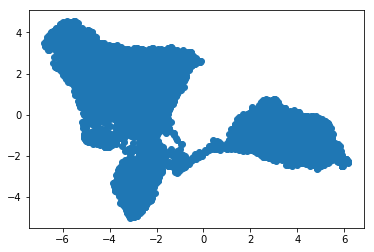

In [129]:
plt.scatter(pos[:,0], pos[:,1])
plt.show()

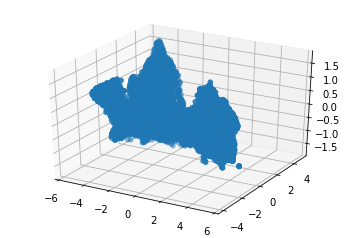

In [133]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:,0], pos[:,1], pos[:,2])
plt.show()

# TSNE

In [88]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=3, 
                  perplexity=50.0, 
                  early_exaggeration=12.0, 
                  learning_rate=200.0, 
                  n_iter=1000, 
                  n_iter_without_progress=300, 
                  min_grad_norm=1e-07, 
                  metric="precomputed", 
                  init="random", 
                  verbose=0, 
                  random_state=None, 
                  method="barnes_hut", 
                  angle=0.5
                 ).fit_transform(distance_final)

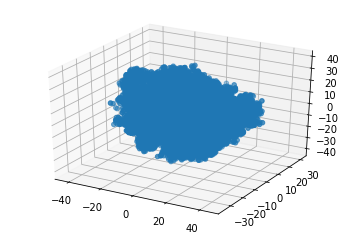

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2])
plt.show()

# SAVE CSV

In [111]:
to_save = df[["primaryTitle"]].reset_index()

In [112]:
to_save["score"] = df.averageRating.values * df.numVotes.values

In [113]:
pos = pd.DataFrame(X_embedded)
pos.columns = ["X", "Y", "Z"]

In [114]:
end = pd.concat([to_save, pos], axis=1).sort_values(by=['score'], ascending = False).reset_index(drop=True)

In [106]:
end.to_csv("perplexite50.csv")

# Export JSON

In [8]:
end = pd.read_csv("perplexite30.csv", index_col=0, encoding="ISO-8859-1")

In [108]:
end.head()

,tconst,primaryTitle,score,X,Y,Z
0,tt0468569,The Dark Knight,17100639.0,20.733547,-13.353313,-7.106080
1,tt0137523,Fight Club,13593632.8,-5.088104,23.465616,5.566605
2,tt0120737,The Lord of the Rings: The Fellowship of the Ring,12290194.4,20.499741,-6.989878,-23.846405
3,tt0167260,The Lord of the Rings: The Return of the King,12256554.9,20.642408,-6.490191,-23.236458
4,tt0133093,The Matrix,12056547.0,31.128233,-1.478713,-16.222563


In [129]:
# end["primaryTitle"] = end["primaryTitle"].str.replace("\'", "\\'")

In [9]:
end.to_json("../datas/new_model30.json")

In [132]:
end

,tconst,primaryTitle,score,X,Y,Z
0,tt0468569,The Dark Knight,17100639.0,20.733547,-13.353313,-7.106080
1,tt0137523,Fight Club,13593632.8,-5.088104,23.465616,5.566605
2,tt0120737,The Lord of the Rings: The Fellowship of the Ring,12290194.4,20.499741,-6.989878,-23.846405
3,tt0167260,The Lord of the Rings: The Return of the King,12256554.9,20.642408,-6.490191,-23.236458
4,tt0133093,The Matrix,12056547.0,31.128233,-1.478713,-16.222563
5,tt1345836,The Dark Knight Rises,10854849.6,21.095131,-13.213118,-8.960325
6,tt0167261,The Lord of the Rings: The Two Towers,10846524.9,20.448780,-6.880366,-23.703226
7,tt0816692,Interstellar,9934350.2,21.509672,-7.666445,-24.504894
8,tt0172495,Gladiator,9504088.0,27.093822,7.254046,-16.520128
9,tt1853728,Django Unchained,9344538.0,3.066151,-18.709913,-4.246237
